In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import msprime as msp
import pandas as pd

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import sys
sys.path.append('../../src/')
from draw_demography import *
from plot_utils import *

%matplotlib inline
%load_ext autoreload

%autoreload 2

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
main_figdir = '../../plots/hap_copying/'
supp_figdir = '../../plots/supp_figs/hap_copying/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

In [3]:
# Reading in the CSV with all of the simulation results
hap_copy_sim_df = pd.read_csv('../../results/hap_copying/simulations/jump_rate_est_sims.csv')
hap_copy_sim_df.head()

,scenario,Ne,scale_marginal,se_scale_marginal,scale_jt,eps_jt,se_scale_jt,se_eps_jt,n_panel,n_snps,ta,min_maf,seed
0,SerialConstant,20000,1425.468341,6.483179,1509.924531,0.004539,6721.293096,0.262004,100.0,199068.0,20.0,1,1
1,SerialConstant,20000,1256.600101,6.083251,1344.356460,0.004059,502.352902,0.076613,100.0,199068.0,40.0,1,1
2,SerialConstant,20000,1132.330687,5.708011,1207.956832,0.003657,110.215938,0.000733,100.0,199068.0,60.0,1,1
3,SerialConstant,20000,1397.285590,6.449425,1470.946716,0.005250,2439.378313,0.093622,100.0,199068.0,80.0,1,1
4,SerialConstant,20000,1303.436500,6.183735,1384.607869,0.004137,80.729524,0.004275,100.0,199068.0,100.0,1,1


In [4]:
def plot_bot_demo(ax, N0=1e4, T_bot=100, b=0.1, **kwargs):
    """Plot bottleneck demography
    """
    xs = np.arange(0, int(10*T_bot))
    ns = np.repeat(N0, xs.size)
    ns[T_bot:] = N0*b
    ax.plot(xs,ns, **kwargs)
    
    
from scipy.stats import linregress 
def split_regression(x,y,split=400):
    """Perform linear regression using datapoints split on X (pre-post bottleneck)
    """
    idx = (x < split)
    return(linregress(x[idx], y[idx]), linregress(x[~idx],y[~idx])) 

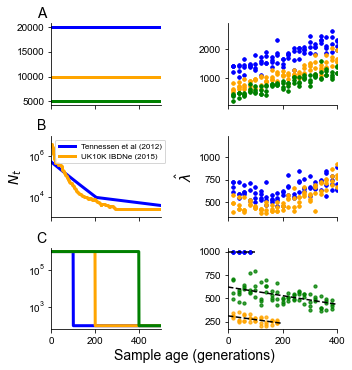

In [5]:
# Generating a finalized figure 
fig, axs = plt.subplots(3,2,figsize=(5,5), sharex='col', tight_layout=True)

Nes = [20000, 10000, 5000]
# Plotting the constants
colors=['blue', 'orange', 'green']
i = 0
for n in Nes:
    axs[0,0].axhline(n, color=colors[i], lw=3)
    filt_df = hap_copy_sim_df[(hap_copy_sim_df.scenario == 'SerialConstant') & (hap_copy_sim_df.Ne == n)]
    # NOTE : we should plot these with error bars and some jitter?
    axs[0,1].scatter(filt_df['ta'].values, filt_df['scale_marginal'].values, color=colors[i], s=10)
    axs[0,1].set_xlim(0,510)
    i += 1
    
    
# Plotting the tennessen and IBDNE demography
tennessen_df = hap_copy_sim_df[hap_copy_sim_df.scenario == 'TennessenEuropean']
ibdne_uk10k_df = hap_copy_sim_df[hap_copy_sim_df.scenario == 'IBDNeUK10K']
axs[1,1].scatter(tennessen_df['ta'].values, tennessen_df['scale_marginal'].values, s=10, color=colors[0])
axs[1,1].scatter(ibdne_uk10k_df['ta'].values, ibdne_uk10k_df['scale_marginal'].values, s=10, color=colors[1])


# TODO : need to plot the demographies down for IBDNE and tennessen
demo_model1_file = {'Tennessen et al (2012)': '../../data/demo_models/tennessen_european.txt', 
                    'UK10K IBDNe (2015)': '../../data/demo_models/uk10k.IBDNe.txt'}
i = 0
for x in demo_model1_file:
    _,demo = read_demography(demo_model1_file[x])
    t,nt = generate_demography(demo)
    axs[1,0].plot(t,nt,lw=3,label=x, color=colors[i])
    i += 1
axs[1,0].set_yscale('log')
axs[1,0].set_ylim(1e3,1e7)
axs[1,1].set_xlim(0,400)
axs[1,0].legend(fontsize=8)
    

# Plotting the instant bottlenecks
n_bot = 0.0001
t_bot = [100,200,400]
nuniq = np.unique(t_bot).size
i = 0
scenarios = ['SerialBottleneckInstant7', 'SerialBottleneckInstant8', 'SerialBottleneckInstant9']
for t in np.unique(t_bot):
    x = scenarios[i]
    filt_instant_bot_df = hap_copy_sim_df[hap_copy_sim_df.scenario == x]
    reg_res_pre_bot, reg_res_post_bot = split_regression(filt_instant_bot_df.ta, filt_instant_bot_df.scale_jt, split=t)
    
    
    idx = (filt_instant_bot_df.ta < t)
    axs[2,1].scatter(filt_instant_bot_df.ta.values[idx], filt_instant_bot_df.scale_jt.values[idx], 
                  s=10, alpha=0.5, color=colors[i])
#     axs[2,1].scatter(filt_instant_bot_df.ta.values[~idx], filt_instant_bot_df.scale_jt.values[~idx], 
#                   s=10, alpha=0.5, color=colors[i])
    
    
    beta = reg_res_pre_bot.slope
    x_test_pre_bot = np.arange(0,t)
    y_test_pre_bot = reg_res_pre_bot.slope*x_test_pre_bot + reg_res_pre_bot.intercept
    axs[2,1].plot(x_test_pre_bot, y_test_pre_bot, linestyle='--', color='black')
    
    plot_bot_demo(axs[2,0], T_bot=t, N0=1000000, b=n_bot, color=colors[i], lw=3)
    i += 1
    
axs[2,0].set_xlim(0,5e2)
axs[2,0].set_yscale('log')


# Debox all of these plots
for ax in axs:
    for a in ax:
        debox(a);

        
for i, label in enumerate(('A', 'B','C')):
    axs[i,0].text(-0.05, 1.2, label, fontsize=14, 
               fontweight='bold', va='top', ha='right', transform=axs[i,0].transAxes);  

# Setting labels
axs[1,0].set_ylabel(r'$N_t$', fontsize=14);
axs[1,1].set_ylabel(r'$\hat{\lambda}$', fontsize=14);
# axs[1,].set_xlabel(r'Sample age (generations)', fontsize=14)
fig.text(0.55, -0.01, r'Sample age (generations)', fontsize=14, ha='center')
plt.tight_layout()
# plt.savefig(main_figdir + 'copying_rate_demography_final.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('../../sandbox/copying_rate_demography_final.pdf', dpi=300, bbox_inches='tight')